# Demo example: filling gaps and missing observations

This example is the continuation of the previous example: [Apply quality control](https://vergauwenthomas.github.io/MetObs_toolkit/examples/qc_example.html). This example serves as a demonstration of how to fill missing observations and gaps. 

In [1]:
import metobs_toolkit
your_dataset = metobs_toolkit.Dataset()
your_dataset.update_settings(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

## Missing observations and Gaps

When there is no (specific) observation value for a timestamp we have a *missing observation*. If there are multiple consecutive timestamps without an observation value and the number of consecutive missing timestamps >= the *gapsize* threshold, we label the period as a gap. 

The default gapsize is set to 40. As mentioned before, the gaps and missing observations are localized when importing the data from file. To change the default gapsize use:

In [2]:
your_dataset.update_qc_settings(gapsize_in_records = 20) 

#Update the gapsize BEFORE importing the data
your_dataset.import_data_from_file()

your_dataset.coarsen_time_resolution(freq='15T')

## Inspect missing observations

To get an overview of the missing observation use the .get_info() method on the missing observations.

In [3]:
your_dataset.missing_obs.get_info()


 -------- Missing observations info -------- 

(Note: missing observations are defined on the frequency estimation of the native dataset.)
  * 3 missing observations

 name
vlinder02   2022-09-10 17:10:00+00:00
vlinder02   2022-09-10 17:15:00+00:00
vlinder02   2022-09-10 17:45:00+00:00
Name: datetime, dtype: datetime64[ns, UTC] 

  * For these stations: ['vlinder02']
  * The missing observations are not filled.
(More details on the missing observation can be found in the .series and .fill_df attributes.)


These missing observations are indicated in time series plots as vertical lines:

<Axes: title={'center': 'Temperatuur of vlinder02'}, xlabel='datetime', ylabel='temp (Celsius)'>

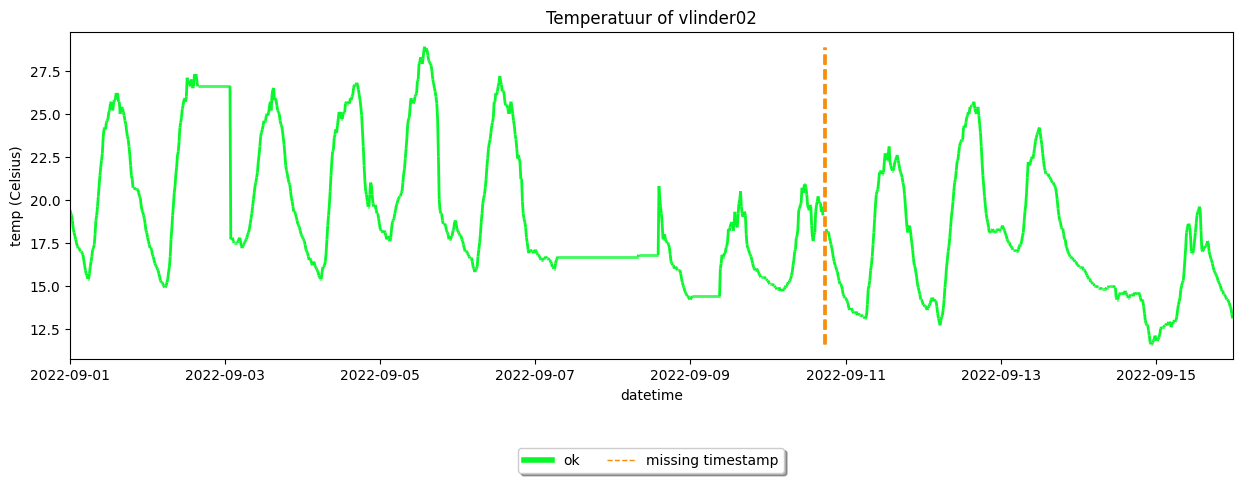

In [4]:
your_dataset.get_station('vlinder02').make_plot(colorby='label')

## Inspect gaps

To get an overview of the gaps use the .get_gap_info() method on the missing Dataset.

In [5]:
your_dataset.get_gaps_info()

There are no gaps.


## Outliers to gaps and missing observations

In practice the observations that are labeled as outliers are interpreted as missing observations (because we assume that the observation value is erroneous). In the toolkit it is possible to convert the outliers to missing observations and gaps by using the [update_gaps_and_missing_from_outliers()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.update_gaps_and_missing_from_outliers).

<Axes: title={'center': 'Temperatuur for all stations. '}, xlabel='datetime', ylabel='temp (Celsius)'>

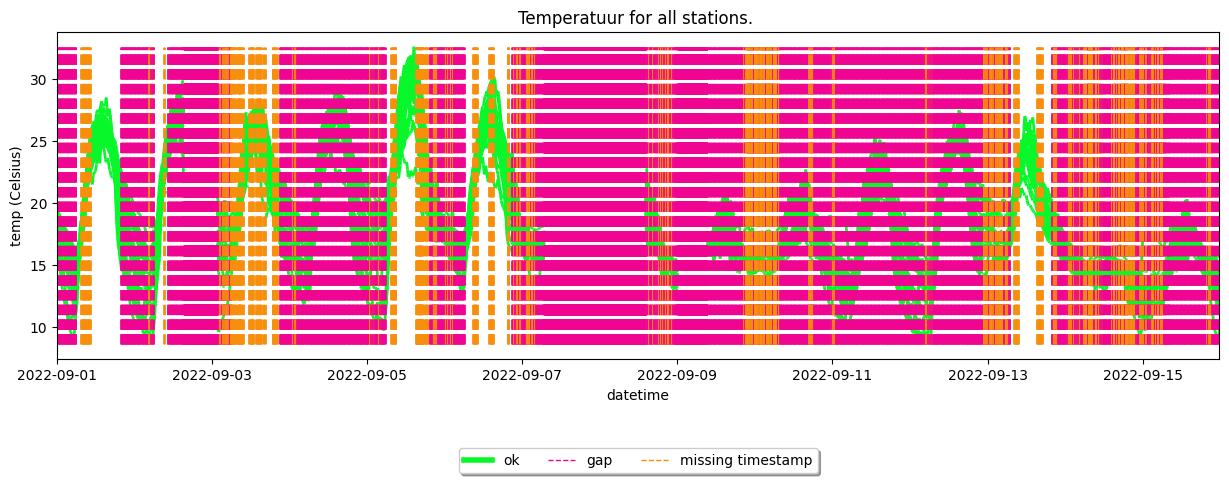

In [6]:
#first apply (default) quality control
your_dataset.apply_quality_control(obstype='temp') #we use the default settings in this example

#Interpret the outliers as missing observations and gaps.
your_dataset.update_gaps_and_missing_from_outliers(obstype='temp', 
                                                   n_gapsize=None) #It is possible to change the definition of gapsize.
#Inspect your gaps using a printout or by plotting
#your_dataset.get_gaps_info()
your_dataset.make_plot(colorby='label')

When plotting a single station, the figure becomes more clear

<Axes: title={'center': 'Temperatuur of vlinder05'}, xlabel='datetime', ylabel='temp (Celsius)'>

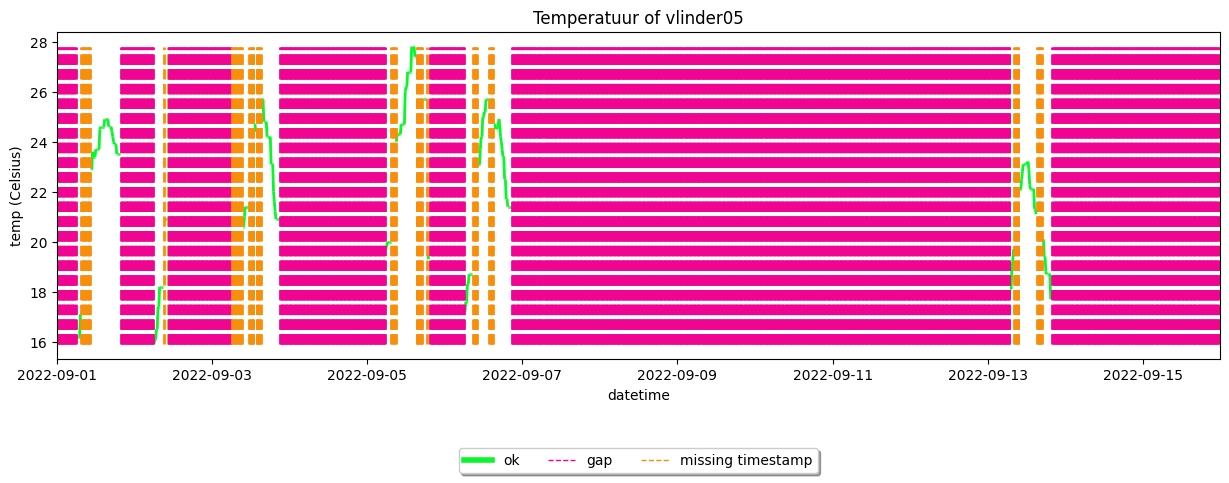

In [7]:
your_dataset.get_station('vlinder05').make_plot(colorby='label')

## Fill missing observations

Missing observations typically span short periods, so interpolation is the most suitable method for filling the observations. To interpolate values over the missing timestamps use the [fill_missing_obs_linear()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.fill_missing_obs_linear) method. The specific settings that are used for the interpolation can be changed with the [update_gap_and_missing_fill_settings()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset_settings_updater.Dataset.html#metobs_toolkit.dataset_settings_updater.Dataset.update_gap_and_missing_fill_settings) method. 


 -------- Missing observations info -------- 

(Note: missing observations are defined on the frequency estimation of the native dataset.)
  * 892 missing observations
  * For 28 stations
  * Missing observations are filled with interpolate for: 
    temp: 
                                           temp
name      datetime                            
vlinder01 2022-09-14 17:45:00+00:00  14.657143
          2022-09-14 18:45:00+00:00  14.485714
          2022-09-14 18:30:00+00:00  14.528571
          2022-09-14 18:15:00+00:00  14.571429
          2022-09-14 18:00:00+00:00  14.614286
...                                        ...
vlinder28 2022-09-12 07:15:00+00:00  13.600000
          2022-09-05 18:15:00+00:00  21.300000
          2022-09-14 18:00:00+00:00  14.800000
          2022-09-14 08:45:00+00:00  15.025000
          2022-09-14 18:15:00+00:00  14.800000

[891 rows x 1 columns]
  * Missing observations that could NOT be filled for: 
    temp: 
 MultiIndex([('vlinder02', '2022-09-10

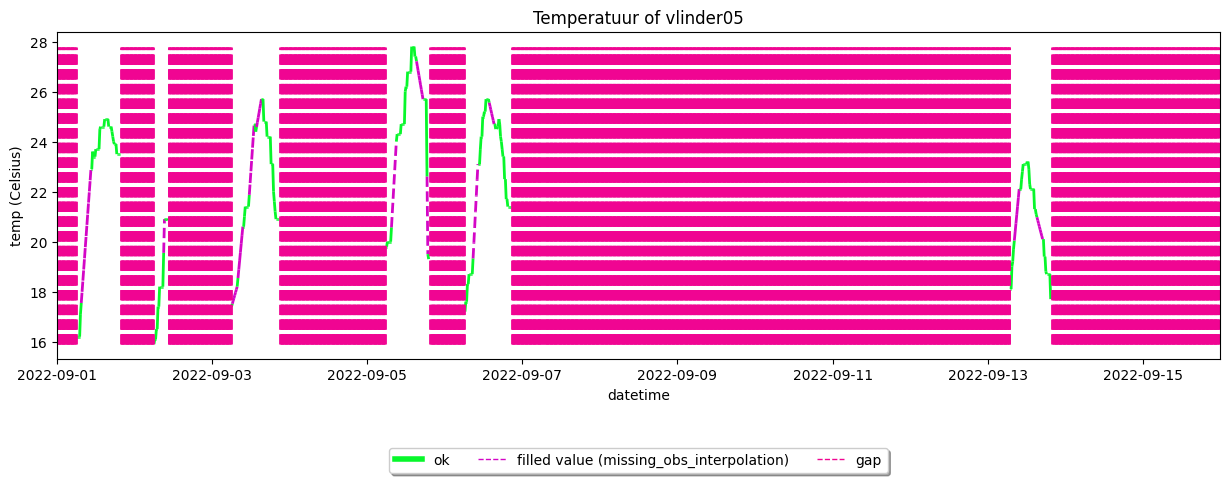

In [8]:
#Update the specific settings
your_dataset.update_gap_and_missing_fill_settings(missing_obs_interpolation_method = 'time')

#Interpolate the missing timestamps
your_dataset.fill_missing_obs_linear(obstype='temp')

#Inspect the filled values by plotting or printing out the info.
your_dataset.get_station('vlinder05').make_plot(colorby='label')
your_dataset.missing_obs.get_info()

## Fill gaps

Because gaps can span longer periods, interpolation is not (always) the most suitable method to fill the gaps. The following method can be used to fill the gaps:
 * interpolation: linear interpolation of the gaps. Use the [fill_gaps_linear()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.fill_gaps_linear) method for this.
 * Debias ERA5 gapfill: Use ERA5 and a debiasing algorithm to fill the gaps by calling the [fill_gaps_era5()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.fill_gaps_era5) method.
 * Automatic gapfill: A combination of the interpolation and ERA5-debias. For the shortest gaps interpolation is used and debias-ERA5 for the longer gaps. Use the [fill_gaps_automatic()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.fill_gaps_automatic) method for this.

Here is an example of using debias ERA5 gapfilling of temperature observations.

In [9]:
#Update the settings (definition of the period to calculate biases for)
your_dataset.update_gap_and_missing_fill_settings(
                                                  gap_debias_prefered_leading_period_hours=24,
                                                  gap_debias_prefered_trailing_period_hours=24,
                                                  gap_debias_minimum_leading_period_hours=6,
                                                  gap_debias_minimum_trailing_period_hours=6,
                                                  )
#(As a demonstration, we will fill the gaps of a single station. The following functions can also be
# directly applied to the dataset.)
your_station = your_dataset.get_station('vlinder05')

### Extracting ERA5 from gee

The modeldata in this example is ERA5 data that is extracted from the google earth engine. See the gee_example for more detailes.

In [10]:
era5_modeldata = your_station.get_equivalent_era5_modeldata(get_obstypes="all")
era5_modeldata.get_info()

Modeldata instance linked to GeeExtractor for ERA5 use: 
   location : ECMWF/ERA5_LAND/HOURLY, containing: 
     * 1 timeseries 
     * The following obstypes are available: ['pressure', 'temp', 'u_comp_wind', 'v_comp_wind', 'wind_amplitude', 'wind_direction'] 
     * Data has these units: ['pa', 'Celsius', 'm/s', 'm/s', 'm/s', 'Â° from north (CW)'] 
     * From 2022-09-01 00:00:00+00:00 --> 2022-09-16 00:00:00+00:00 (with tz=UTC) 
 
 (Data is stored in the .df attribute)


Now we can use this Modeldata to fill the gaps using the debias method.

In [11]:
#Use the debias method to fill the gaps
gapfill_df = your_station.fill_gaps_using_debiased_modeldata(modeldata=era5_modeldata, obstype='temp')

The gaps in the station are now filled. To inspect these filled values, you can plot them

<Axes: title={'center': 'Temperatuur of vlinder05'}, xlabel='datetime', ylabel='temp (Celsius)'>

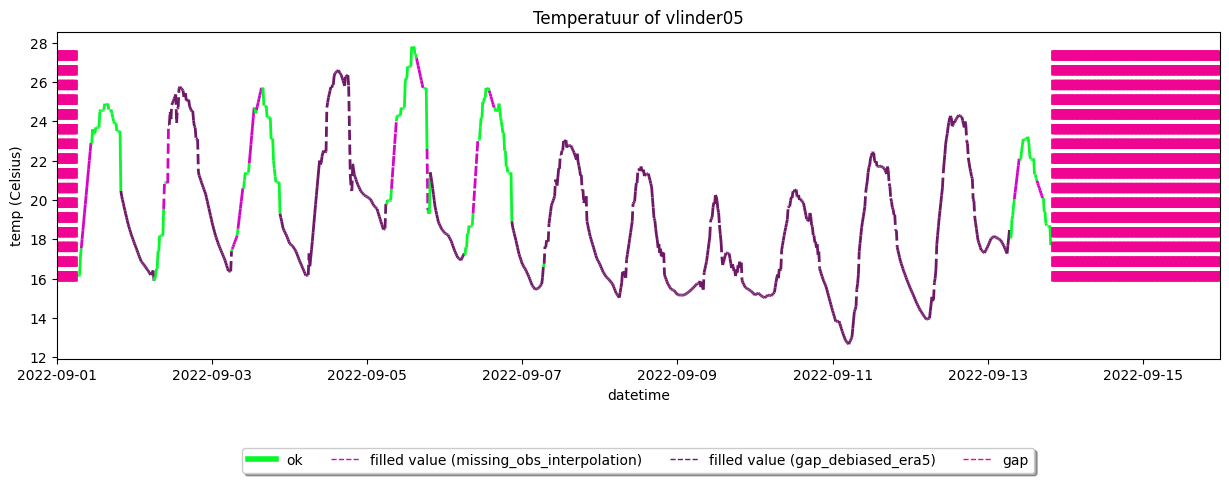

In [12]:
your_station.make_plot(colorby='label')

If you want more details you can inspect the DataFrame with the gapfill values, or print out the information.

In [13]:
#inspect the gapfilldf attribute direct
your_station.gapfilldf.head()

#or print out info
#your_station.get_gaps_info()

temp_final_label       temp
name      datetime                                               
vlinder05 2022-09-01 19:45:00+00:00  gap_debiased_era5  20.470136
          2022-09-01 20:00:00+00:00  gap_debiased_era5  20.200433
          2022-09-01 20:15:00+00:00  gap_debiased_era5  20.018491
          2022-09-01 20:30:00+00:00  gap_debiased_era5  19.836549
          2022-09-01 20:45:00+00:00  gap_debiased_era5  19.654607

## Filling gaps exercise

For a more detailed reference you can use this [Filling gaps exercise](https://github.com/vergauwenthomas/MetObs_toolkit/blob/master/examples/Gap_filling_excercise_03.ipynb), which was created in the context of the [COST FAIRNESS](https://www.cost.eu/actions/CA20108/) summer school 2023 in Ghent.